# Weakly-supervised semantic segmentation with seeds and boxes
Claire Sheng (y44sheng@uwaterloo.ca), Mingxiao Zhang (m468zhan@uwaterloo.ca), Shuyao Shi(s56shi@uwaterloo.ca)

### Abstract
The project aims to develop a robust weakly-supervised semantic segmentation model with seeds and boxes where ground truth annotations are unavailable. Our main focus is to design different models and loss functions to tackle this problem. We experimented our models on both segmentations with seeds and boxes to compare the outcomes with different data types.


We implemnented a U-net model, which captures features in the contracting encoding path and reconstruct the image based on the features in the expansive decoding path. The U-shaped structure of U-net perservses high-resolution features and help preventing losing key features along the path. For the encoder we employed ResNet18, an ImageNet pretrained model that could help us simplify the training task. For loss functions, we have experimented with various techniques including corss entropy over seeds and pairewise regularization loss for seed data and dice loss for box level data. Cross entropy over seeds prioritize segments associated with the provided seeds while pairewise regularization loss encourages consistency in predictions between neighboring pixels. We have also compared different testing results with the loss functions. Overall we evaluated the trade-offs, strengths, and limitations of the U-Net model in weakly-supervised training with seed and box level data, as well as the impact of different loss functions.

The data are from PASCAL 2012 dataset.
Image and box data: [address](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html)
Scribble data: [address](https://jifengdai.org/downloads/scribble_sup/)

 ### Team members and contributions
 * Claire Sheng (y44sheng@uwaterloo.ca): Model research and design, documentation and conclusion for box-level data. 
 * Mingxiao Zhang (m468zhan@uwaterloo.ca): Created model for UNet architecture, processed and experimented with box-level object data for image segmentation.
 * Shuyao Shi(s56shi@uwaterloo.ca): Completed the seed-based semantic segmentation except for the model design, including xml file extraction, loss function design, hyperparameter fine tune, seed-level data processing and experiment, and documentation.

### Code libraries
* xml.etree.ElementTree: parse XML files
* os: handle file paths, perform various file system operations
* numpy: handle numerical operations
* torch: provides tensor operations
* torch.nn: offer neural network-related functionalities
* torch.optim: provide optimization algorithms necessary for updating the model parameters during training
* torch.utils.data.DataLoader & Dataset: handle datasets and data loading
* transforms from torchvision: provides a set of image transformations essential for preprocessing data
* models from torchvision: offer pre-trained deep learning models including ResNet
* tqdm: provide a convenient progress bar for tracking iterations during training a deep learning model
* PIL: enable image opening, manipulation, and conversion
* matplotlib: visualize images, model outputs
* train_test_split from sklearn.model_selection: split of your dataset into training and validation sets
* ToPILImage from torchvision.transforms: convert a PyTorch tensor or numpy array to a PIL Image
* matplotlib.colors & matplotlib.pyplot: customize colors and create visualizations
* relu from torch.nn.functional: use ReLU(rectified linear activation function)
* randint from random: generating random integers


## Weakly-supervised Semantic Segmentation with Seeds

### Import Code Libraries

In [ ]:
import xml.etree.ElementTree as ET
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

### Part 1: Parsing and reading scribble information

### In this section, we focus on extracting relevant information from the XML files and transform it into a format suitable for the segmentation model.
### XML file structure:
```xml
<annotation>
	<folder>anno</folder>
	<filename>000001.png</filename> \\ The file name of the image
	<source>
		...
	</source>
	<owner>
		...
	</owner>
	<size>
		<width>706</width>          \\ The width of the image
		<height>500</height>        \\ The height of the image
		<depth>3</depth>            \\ The depth of the image
	</size>
	<segmented>1</segmented>
	<polygon>                       \\ The start of a scribble
		<tag>person</tag>
		<point>                     \\ The coordinate of a pixel in the scribble
			<X>167</X>
			<Y>46</Y>
		</point>
		...
	</polygon>                      \\ The end of a scribble
</annotation>
```
### The parsing process involves the following steps:

### 1. Extracting metadata:
### This step extracts the filename, width and height of the image. Filename will be used to find the corresponding input image file, the width and height will be used to resize the scribble coordinates.
<br>

### 2. Reading scribble points:
### For each polygon element, it includes the class tag and the coordinates of related scribbles. These coordinates are represented as (X, Y) pairs within the point tags.
<br>

### 3. Resizing coordinates:
### Since ResNet will be used as the model and it only accepts $224*224$ sized image, the scribble coordinates are adjusted to match this new image size. This resizing ensures that the scribbles correctly correspond to the relevant points in the resized image.
<br>

### 4. Creating tensor:
### We use a tensor of dimensions $22*224*224$, the first dimension corresponds to the classes stated in the class-mapping section. If a scribble for a certain class exists at a specific location, the corresponding element in the tensor is set to 1.

In [ ]:
class_mapping = {
    'person': 0,
    'bird': 1,
    'cat': 2,
    'cow': 3,
    'dog': 4,
    'horse': 5,
    'sheep': 6,
    'aeroplane': 7,
    'plane': 7,
    'bike': 8,
    'bicycle':8,
    'boat': 9,
    'bus': 10,
    'car': 11,
    'motorbike': 12,
    'train': 13,
    'bottle': 14,
    'chair': 15,
    'diningtable': 16,
    'table':16,
    'pottedplant': 17,
    'plant': 17,
    'sofa': 18,
    'tvmonitor': 19,
    'monitor': 19,
    'background': 20,
    'void': 255
}

### Part 2: Reading data and preparing dataset and dataloader

### In this section, we focus on preparing the datasets and dataloaders for training and validating. This involves defining a custom dataset class, applying necessary transformations, and setting up dataloaders.
<br>

### a) Custom dataset class--scribble dataset
### This dataset class consists of 3 functions, initialization, get length, and get item function.
### Initialization: The paths and a list of all xml files are stored for later use in loading data.
### Length Method: Return the size of the dataset.
### Get Item Method: This method reads XML file to get scribble information using the funtion defined above and use the filename to load the associated image. The image is then transformed and packed with the tensor created by the read_scribble_xml function.
<br>

### b) ToTensor function: This function resizes the image into $224*224$ for later training.
<br>

### c) Setting up dataset and dataloader
### The dataset is split into training and validation sets using the train_test_split function, ensuring a portion of data is reserved for model evaluation. Moreover, we set the batch size to be 16 to increase the speed of training and avoid overfitting.

In [ ]:
def read_scribble_xml(xml_file):
    #  Parse XML into Element Tree
    tree = ET.parse(xml_file)
    root = tree.getroot()

    #  Read meta data
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    #  Read all points and assign them to the tensor
    tensor_categories = torch.zeros((22, 224, 224))


    polygons = root.findall('polygon')
    for polygon in polygons:
        tag = polygon.find('tag').text
        points = np.array([(min(int(int(point.find('X').text)/width*224), 223), min(int(int(point.find('Y').text)/height*224),223)) for point in polygon.findall('point')])
        tensor_categories[class_mapping[tag], points[:, 1], points[:, 0]] = 1

    return filename, tensor_categories


In [ ]:
# Define dataset
class ScribbleDataset(Dataset):
    def __init__(self, image_dir, xml_dir, xml_files, transform=None):
        self.image_dir = image_dir
        self.xml_files = xml_files
        self.transform = transform
        self.xml_dir = xml_dir

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_file = self.xml_files[idx]
        xml_path = os.path.join(self.xml_dir, xml_file)
        image_path = os.path.join(self.image_dir, xml_file.replace(".xml", ".jpg"))

        filename, tensor_categories = read_scribble_xml(xml_path)
        image = Image.open(image_path)

        sample = {'filename':filename,'image': image, 'tensor_category': tensor_categories}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [ ]:
class ToTensor(object):
    def __call__(self, sample):
        filename, image, tensor_categories = sample['filename'], sample['image'], sample['tensor_category']

        # Convert image to tensor
        image = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])(image)

        return {'filename':filename, 'image': image, 'tensor_category': tensor_categories}

In [ ]:
# Set up dataset and dataloader
xml_dir = "scribble"
image_dir = "data/VOCdevkit/VOC2012/JPEGImages"
xml_list = os.listdir(xml_dir)
transform = transforms.Compose([ToTensor()])
train_data, val_data = train_test_split(xml_list, test_size=0.1, random_state=1)
train_dataset = ScribbleDataset(image_dir=image_dir, xml_dir=xml_dir, xml_files=train_data, transform=transform)
val_dataset = ScribbleDataset(image_dir=image_dir, xml_dir=xml_dir, xml_files=val_data, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Part 3: define model for training

### In this section, we focus on defining a suitable CNN model (UNet) for semantic segmentation. There are 3 key components for the UNet model.

### 1. Initialization:
### The initialization uses a pretrained ResNet-18 model as the encoder. One advantage is this model will gett high level information from the pretrained model which is trained on a much larger dataset.
<br>

### 2. Encoder:
### The encoder is formed by using the layers of the ResNet-18 model, excluding the last two layers due to the need for decoding.
<br>

### 3. Decoder:
### The decoder is a sequence of convolutional and upsampling layers to upsample the feature maps and restores the spatial dimensions. The decoder uses transposed convolutions and ReLU to construct higher-resolution feature maps. The final layer is a transposed convolution that maps the features to the number of classes, followed by a Softmax layer for class probability predictions.

In [6]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        resnet18 = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part 4: Loss function

### In this section, we focus on defining loss functions for training and validation. First, we implement the partial cross entropy loss to ensure the pixels marked by the scribbles are predicated correctly. However, given the nature of weakly supervised learning, there is no ground truth information for all pixels; so we need to use a regularizaer to ensure the smoothness of the original graph is kept in the predicated segmentation. Note we used mean instead of sum because using sum for loss calculation will be influenced by the batch size and the number of scribbles in the scribble file. It's also important to keep a balance between the partial cross entropy loss and the regularization loss, because if the partial cross entropy loss dominates, then the model won't care the spatial coherence but only based on the scribble information; however, if the regularization loss dominates, the model will tend to predicate every pixel as background since the regularization loss will be 0 in this case.
<br>

### 1. Partial cross entropy:
### This loss function is designed to calculate the cross-entropy loss specifically at the scribble locations. $-\sum_{p\in scribbles} \log S_p^{y_p}$ and $w_{pq}\propto \exp\frac{-\lambda \|I_p-I_q\|^2}{\sigma^2}$
### First, the probabilities are clamped to avoid log of zero which can lead to nan in calculation. Second, only the probabilities at the locations of the scribbles are selected for the loss computation. Finally, the negative log likelihood function is used to obtain the final loss.
<br>

### 2. N-link loss:
### The n-link loss aims to ensure spatial coherence in the segmentation predication. $\sum_{pq\in N} w_{pq}\,[S_p \neq S_q]$,
### Link weights are calculated based on the L2 norm between adjacent pixels. The final loss is computed as the sum of link weights in the original graph times the sum of link weights in the predicated segmentation. However, the summation caused a mixture of different weights which lead to error in calculation. So, another n-link loss function is defined.

### 3. Pairwise regularization loss(ir n-link loss):
### The pairwise regularization loss aims to ensure spatial coherence in the segmentation predication.
### Link weights are calculated based on the L2 norm between adjacent pixels in both input and output images in all four directions (right, left, top, bottom). The final loss is computed as the sum of link weights in the original graph times the sum of link weights in the predicated segmentation. The final loss is the mean of the weighted combination of the L2 norms of input and output image.

In [7]:
# define cross entropy
class Partial_Cross_Entropy(nn.Module):
    def __init__(self):
        super(Partial_Cross_Entropy, self).__init__()

    def forward(self, predictions, scribbles, epsilon=1e-6):
        predictions_clamped = torch.clamp(predictions, min=epsilon)

        # Select the probabilities where there are scribbles
        selected_probabilities = predictions_clamped[scribbles.bool()]

        # Calculate the negative log likelihood
        loss = -torch.log(selected_probabilities).mean()

        return loss


In [ ]:
class N_Link_Loss(nn.Module):
    def __init__(self):
        super(N_Link_Loss, self).__init__()

    def forward(self, inputs, predication):
        sigma_sqr = 0.0025
        var_lambda = 100
        #  Calculate link weight over the batch
        n_right_weight = var_lambda*torch.exp(-torch.linalg.norm(torch.roll(inputs, shifts=1, dims=2) - inputs, dim=1) / (2*sigma_sqr))
        n_below_weight = var_lambda*torch.exp(-torch.linalg.norm(torch.roll(inputs, shifts=1, dims=3) - inputs, dim=1) / (2*sigma_sqr))

        n_link_weight = n_right_weight + n_below_weight

        #  Calculate predication L2 norm over the batch
        n_right_coherence = torch.linalg.norm(torch.roll(predication, shifts=1, dims=2) - predication, dim=1)
        n_below_coherence = torch.linalg.norm(torch.roll(predication, shifts=1, dims=3) - predication, dim=1)
        n_link_coherence = n_right_coherence + n_below_coherence

        n_link_loss = (n_link_coherence*n_link_weight).sum()

        return n_link_loss


In [ ]:
class PairwiseRegularizationLoss(nn.Module):
    def __init__(self):
        super(PairwiseRegularizationLoss, self).__init__()

    def forward(self, input_img, output_img):
        var_lambda = 25
        sigma_sqr = 0.0025
        # Calculate pairwise differences for input and output images
        right_diff_input = torch.roll(input_img, shifts=1, dims=3) - input_img
        below_diff_input = torch.roll(input_img, shifts=1, dims=2) - input_img
        top_diff_input = torch.roll(input_img, shifts=-1, dims=2) - input_img
        left_diff_input = torch.roll(input_img, shifts=-1, dims=2) - input_img

        right_diff_output = torch.roll(output_img, shifts=1, dims=3) - output_img
        left_diff_output = torch.roll(output_img, shifts=-1, dims=3) - output_img
        below_diff_output = torch.roll(output_img, shifts=1, dims=2) - output_img
        top_diff_output = torch.roll(output_img, shifts=-1, dims=2) - output_img

        # Calculate L2 norms
        right_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(right_diff_input, dim=1) / sigma_sqr)
        below_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(below_diff_input, dim=1) / sigma_sqr)
        left_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(left_diff_input, dim=1) / sigma_sqr)
        top_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(top_diff_input, dim=1) / sigma_sqr)

        right_norm_output = torch.linalg.norm(right_diff_output, dim=1)
        below_norm_output = torch.linalg.norm(below_diff_output, dim=1)
        left_norm_output = torch.linalg.norm(left_diff_output, dim=1)
        top_norm_output = torch.linalg.norm(top_diff_output, dim=1)

        # Calculate weighted loss
        loss = ((right_norm_output * right_norm_input) + (below_norm_output * below_norm_input) + (left_norm_output * left_norm_input) + (top_norm_output * top_norm_input)).mean()

        return loss

### Part 5: model training

### In this section, we focus on training the model by defining training function and testing function.

### Initialization:
### Initiate the UNet model, loss functions and optimizers. The model and loss functions are discussed above, we choose adam optimizer because of its efficiency and adaptive leraning rate capabilities. The number of epoch is set to 6 because the validation loss usually starts to increase after 6 epoch, meaning that the model starts overfitting.
<br>

### Training and validation function:
### They iterate over the dataset, computes the forward pass, calculate the loss based on the loss function, and then performs a backward propagation if it's in the training phase.

In [ ]:
# Initialize U-Net model
in_channels = 3
out_channels = 22  # Number of classes
model_UNet = UNet(out_channels)
num_epochs = 6

# Define loss function and optimizer
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = N_Link_Loss()
criterion_3 = PairwiseRegularizationLoss()
criterion_4 = Partial_Cross_Entropy()
optimizer = optim.Adam(model_UNet.parameters(), lr=0.001)

# Set device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
model_UNet.to(device)

cuda


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Train function for image dataset
def train_image(model, dataloader, optimizer, device):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    train_PCE_loss = 0
    train_r_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, targets = batch['image'].to(device), batch['tensor_category'].to(device)
        # Forward pass
        outputs = model(images)
        # Compute your loss based on the weak annotation
        PCE_loss = criterion_4(outputs, targets)
        r_loss= criterion_3(images, outputs)
        loss = PCE_loss+r_loss
        train_PCE_loss += PCE_loss.item()
        train_r_loss += r_loss.item()
        train_loss += loss.item()
        #print(criterion_4(outputs, targets).item())
        #print(criterion_3(images, outputs).item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    average_PCE_loss = train_PCE_loss / num_batches
    average_r_loss = train_r_loss / num_batches
    return average_train_loss, average_PCE_loss, average_r_loss

In [ ]:
# Test function for image dataset
def test_image(model, dataloader, device):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    test_PCE_loss = 0
    test_r_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, targets = batch['image'].to(device), batch['tensor_category'].to(device)
            outputs = model(images)

            PCE_loss = criterion_4(outputs, targets)
            r_loss= criterion_3(images, outputs)
            loss = PCE_loss+r_loss

            test_PCE_loss += PCE_loss.item()
            test_r_loss += r_loss.item()
            test_loss += loss.item()

    average_test_loss = test_loss / num_batches
    average_PCE_loss = test_PCE_loss / num_batches
    average_r_loss = test_r_loss / num_batches
    return average_test_loss, average_PCE_loss, average_r_loss

In [ ]:
# Training loop
for epoch in range(num_epochs):
    train_loss, train_PCE_loss, train_r_loss = train_image(model_UNet, train_dataloader, optimizer, device)
    validation_loss, test_PCE_loss, test_r_loss = test_image(model_UNet, val_dataloader, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} PCE Loss: {train_PCE_loss:.4f} Regularization Loss: {train_r_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f} PCE Loss: {test_PCE_loss:.4f} Regularization Loss: {test_r_loss:.4f}")

# Save or use the trained model for inference
torch.save(model_UNet.state_dict(), 'seeds_weakly_supervised_segmentation_model.pth')

Epoch 1/6: 100%|██████████| 76/76 [00:09<00:00,  8.12it/s]


Epoch [1/6]
Train Loss: 1.6641 PCE Loss: 1.6008 Regularization Loss: 0.0633
Validation Loss: 1.5315 PCE Loss: 1.4802 Regularization Loss: 0.0512


Epoch 2/6: 100%|██████████| 76/76 [00:09<00:00,  8.15it/s]


Epoch [2/6]
Train Loss: 1.4268 PCE Loss: 1.3776 Regularization Loss: 0.0492
Validation Loss: 1.3134 PCE Loss: 1.2673 Regularization Loss: 0.0462


Epoch 3/6: 100%|██████████| 76/76 [00:09<00:00,  8.36it/s]


Epoch [3/6]
Train Loss: 1.2447 PCE Loss: 1.1952 Regularization Loss: 0.0495
Validation Loss: 1.2691 PCE Loss: 1.2198 Regularization Loss: 0.0493


Epoch 4/6: 100%|██████████| 76/76 [00:09<00:00,  8.33it/s]


Epoch [4/6]
Train Loss: 1.1103 PCE Loss: 1.0562 Regularization Loss: 0.0541
Validation Loss: 1.1137 PCE Loss: 1.0612 Regularization Loss: 0.0526


Epoch 5/6: 100%|██████████| 76/76 [00:09<00:00,  8.37it/s]


Epoch [5/6]
Train Loss: 0.9911 PCE Loss: 0.9354 Regularization Loss: 0.0557
Validation Loss: 1.0171 PCE Loss: 0.9571 Regularization Loss: 0.0600


Epoch 6/6: 100%|██████████| 76/76 [00:09<00:00,  8.29it/s]

Epoch [6/6]
Train Loss: 0.9029 PCE Loss: 0.8457 Regularization Loss: 0.0572
Validation Loss: 0.9930 PCE Loss: 0.9377 Regularization Loss: 0.0553


### Part 6: visualize results

### In this section, we focus on visualizing the segmentation results of the trained model.

### A color mapping is created to visually differentiate between the 22 classes. The model predicts the class for each pixel in the selected image. The prediction is a tensor representing the most likely class for each pixel.

In [ ]:
class_list = [i for i in range(1, 22)]
pascal_voc_colors = [
    "#FF0000",  # Red
    "#00FF00",  # Lime
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#00FFFF",  # Cyan
    "#FF00FF",  # Magenta
    "#800000",  # Maroon
    "#808000",  # Olive
    "#008000",  # Green
    "#800080",  # Purple
    "#008080",  # Teal
    "#000080",  # Navy
    "#FFA500",  # Orange
    "#A52A2A",  # Brown
    "#20B2AA",  # Light Sea Green
    "#778899",  # Light Slate Gray
    "#B0C4DE",  # Light Steel Blue
    "#FFFFE0",  # Light Yellow
    "#00FA9A",  # Medium Spring Green
    "#FFD700",  # Gold
    "#000000",  # black
    "#FF69B4"   # Hot Pink
]
print(len(pascal_voc_colors))
cmap = mcolors.LinearSegmentedColormap.from_list(class_list, pascal_voc_colors)

22


In [ ]:
print(class_mapping)

{'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7, 'plane': 7, 'bike': 8, 'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14, 'chair': 15, 'diningtable': 16, 'table': 16, 'pottedplant': 17, 'plant': 17, 'sofa': 18, 'tvmonitor': 19, 'monitor': 19, 'background': 20, 'void': 255}


tensor(8, device='cuda:0')


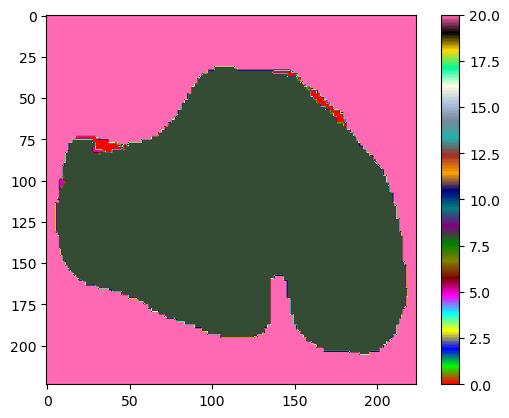

In [ ]:
model_UNet.eval()
image_number = 123
tensor = model_UNet(val_dataset[image_number]['image'].to(device).unsqueeze(0)).squeeze(0)
normalized_tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
predicted_classes = torch.argmax(tensor, dim=0)
plt.imshow(predicted_classes.cpu(), cmap=cmap)
print(predicted_classes[125][50])
#plt.imshow(val_dataset[3]['image'].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

2008_005603.jpg


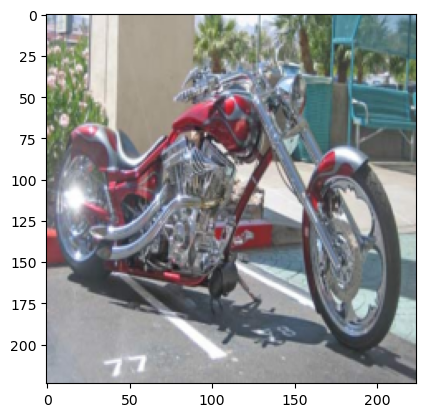

In [ ]:
plt.imshow(val_dataset[image_number]['image'].permute(1, 2, 0).numpy())
print(val_dataset[image_number]['filename'])
#print(val_dataset[3]['tensor_category'])

## Weakly-supervised Semantic Segmentation with Boxes

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class_mapping = {
    'person': 1,
    'bird': 2,
    'cat': 3,
    'cow': 4,
    'dog': 5,
    'horse': 6,
    'sheep': 7,
    'aeroplane': 8,
    'plane': 9,
    'bike': 10,
    'bicycle':11,
    'boat': 12,
    'bus': 10,
    'car': 11,
    'motorbike': 12,
    'train': 13,
    'bottle': 14,
    'chair': 15,
    'diningtable': 16,
    'table':16,
    'pottedplant': 17,
    'plant': 17,
    'sofa': 18,
    'tvmonitor': 19,
    'monitor': 19,
    'background': 0,
}

### Data Preprocessing

### The `to_target_tensor` function takes in XML data of bounding boxes and converts them to binary masks for each object class, outputing a tensor of shape (21, 224, 224) as the target output of the model.

In [3]:
def to_target_tensor(num_classes, annotation_dict):
    # Extract image size information
    width = int(annotation_dict['annotation']['size']['width'])
    height = int(annotation_dict['annotation']['size']['height'])

    # Extract bounding box information
    tensor_categories = torch.zeros((num_classes, 224, 224))
    tensor_categories[0, :, :] = 1
    for obj in annotation_dict['annotation']['object']:
        xmin = int((int(obj['bndbox']['xmin']) / width) * 224)
        ymin = int((int(obj['bndbox']['ymin']) / height) * 224)
        xmax = int((int(obj['bndbox']['xmax']) / width) * 224)
        ymax = int((int(obj['bndbox']['ymax']) / height) * 224)
        tensor_categories[class_mapping[obj['name']], ymin:ymax+1, xmin:xmax+1] = 1
        tensor_categories[0, ymin:ymax+1, xmin:xmax+1] = 0

    return tensor_categories

In [4]:
num_classes = 21
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
target_transform = transforms.Compose([
    transforms.Lambda(lambda x: to_target_tensor(num_classes, x))
])
train_dataset = VOCDetection(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
print(train_dataset[0][1].shape)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 1999639040/1999639040 [01:28<00:00, 22679128.40it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
torch.Size([21, 224, 224])


In [9]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1.,
                           eps=self.eps, threshold=None,
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = UNet(num_classes=21).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion2 = BCEDiceLoss(eps=1.0, activation=None)
criterion3 = Partial_Cross_Entropy()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [13]:
# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    for images, annotations in train_loader:
        images, annotations = images.to(device), annotations.to(device)

        # Forward pass
        outputs = model(images)
        # Compute loss based on the weak annotations
        loss = criterion3(outputs, annotations)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save or use the trained model for inference
torch.save(model.state_dict(), 'weakly_supervised_segmentation_model.pth')

Epoch [1/25], Loss: 2.0106
Epoch [2/25], Loss: 1.6650
Epoch [3/25], Loss: 1.4377
Epoch [4/25], Loss: 1.3278
Epoch [5/25], Loss: 0.9553
Epoch [6/25], Loss: 1.2687
Epoch [7/25], Loss: 1.1127
Epoch [8/25], Loss: 0.6677
Epoch [9/25], Loss: 0.8329
Epoch [10/25], Loss: 0.5996
Epoch [11/25], Loss: 0.8005
Epoch [12/25], Loss: 0.4509
Epoch [13/25], Loss: 0.5499
Epoch [14/25], Loss: 0.8161
Epoch [15/25], Loss: 0.4360
Epoch [16/25], Loss: 0.4061
Epoch [17/25], Loss: 0.5184
Epoch [18/25], Loss: 0.4339
Epoch [19/25], Loss: 0.3056
Epoch [20/25], Loss: 0.3433
Epoch [21/25], Loss: 0.3323
Epoch [22/25], Loss: 0.2340
Epoch [23/25], Loss: 0.2278
Epoch [24/25], Loss: 0.2695
Epoch [25/25], Loss: 0.2264


### Visualize Result:

### The results of the UNet model trained using Partial Cross Entropy loss with box level labels can be seen below on both the training set and unseen testing data. The model is able to output a prediction of the segments in the image within a certain range but cannot create a fully accurate prediction. 

### The output of the model on unseen data is less precise. While it can still output a general range for the object, it cannot generate a precise prediction on the class of the object compared to its performance on training data.

(21, 224, 224)


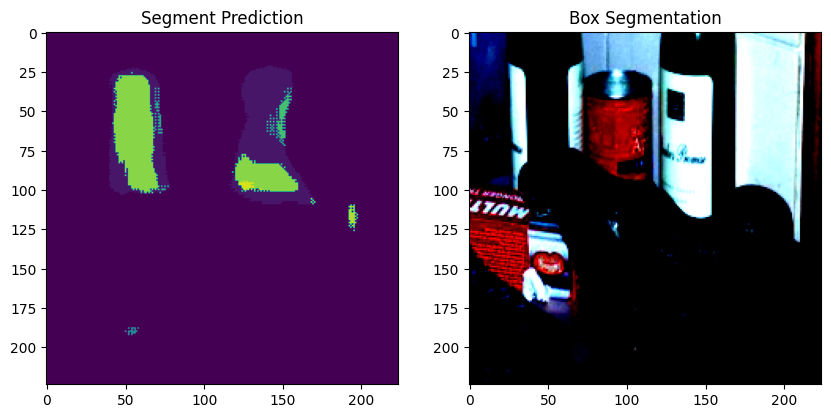

In [24]:
# Training set data
from torchvision.transforms import ToPILImage
from PIL import Image

tensor = model(train_dataset[1][0].unsqueeze(0).to('cuda')).squeeze(0)
normalized_tensor = ((tensor - tensor.min()) / (tensor.max() - tensor.min())).cpu().detach().numpy()

output = np.argmax(normalized_tensor, axis=0)
target = torch.argmax(train_dataset[1][1], dim=0).numpy()
print(normalized_tensor.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(output)
axes[0].set_title('Segment Prediction')

axes[1].imshow(np.transpose(train_dataset[1][0], (1, 2, 0)))
axes[1].set_title('Box Segmentation')


plt.show()

In [14]:
from torchvision.datasets import VOCSegmentation

voc_test_dataset = VOCSegmentation(root='./test', image_set='val', download=True, transform=transform)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(voc_test_dataset, batch_size=1, shuffle=False)

100%|██████████| 1999639040/1999639040 [01:28<00:00, 22722778.75it/s]


Extracting ./test/VOCtrainval_11-May-2012.tar to ./test


(21, 224, 224)


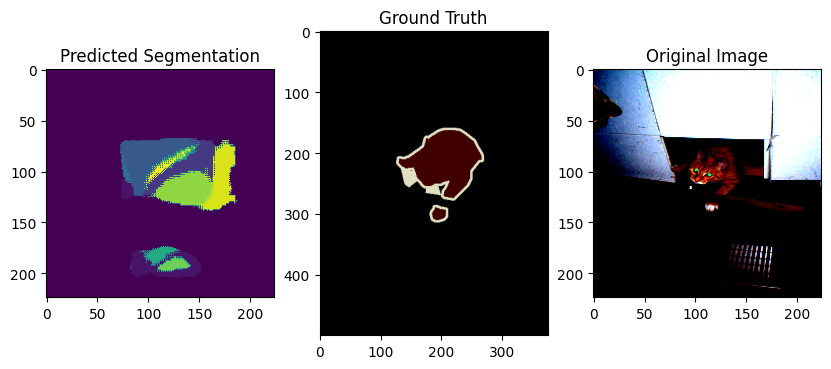

In [15]:
# Testing set data
from torchvision.transforms import ToPILImage
from PIL import Image

tensor = model(voc_test_dataset[1000][0].unsqueeze(0).to('cuda')).squeeze(0)
normalized_tensor = ((tensor - tensor.min()) / (tensor.max() - tensor.min())).cpu().detach().numpy()

output = np.argmax(normalized_tensor, axis=0)
target = torch.argmax(train_dataset[2][1], dim=0).numpy()
print(normalized_tensor.shape)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(output)
axes[0].set_title('Predicted Segmentation')

axes[1].imshow(voc_test_dataset[1000][1])
axes[1].set_title('Ground Truth')

axes[2].imshow(np.transpose(voc_test_dataset[1000][0], (1, 2, 0)))
axes[2].set_title('Original Image')

plt.show()

### Conclusion

#### Scribble-based
This project aimed to develop and evaluate a semantic segmentation model using a scribble-based weakly supervised learning approach. The method consists several parts, including class mapping, parsing scribble annotations, dataset preparation, model definition, custom loss function implementation, training, and finally, visualization of results.

First, the project successfully demonstrated how scribbles can be utilized to train a semantic segmentation model. This approach significantly reduces the annotation effort compared to pixel-wise annotations. Second, the integration of custom loss functions like partial cross entropy and pairwise regularization loss played an important role in guiding the model to focus on scribbles while maintaining enough spatial coherence from the original image.

However, while the project achieved significant milestones, there are still some places to be improved. For instance, the model can only make imperfect segmentations, some common mistakes are identifying motor as bike, car as bus and so on, this is probably because the number of training data is not enough for the model to learn enough high level features of these similar objects. Second, as the scribbles are treated as hard constraint in our model, the quality of scribbles will largely influence the performance of the model. Third and most importantly, it's hard to find a balance between loss functions to avoid dominance of either loss function. Lastly, when we resize the image, we will lose some features from the original point; even worse, two scribbles may collide with each other especially bad if they are different.

To address these limitations and enhance the model's performance, we may redefine the loss function to allow it to utilize some high level features instead of just the hard constraints and spatial coherence to better capture other information. The model architecture may also need to be modified, instead of resizing the image to smaller size, it may be better to augment the image to a larger size to avoid loss of features and collision between scribbles.

Overall, despite some limitations in the segmentation accuracy, the approach shows the feasibility of seed-based weakly-supervised semantic segmentation, where model can learn the feature from only smaller amount of supervision, which largely reduced the labeling effort.


### Box-based

This project focuses on developing a weakly-spuervised semantic segmentation model with boxes. The methodologies are similar to the sribble-based part, including class mapping, dataset preprocessing, model defining, training and visualization.

Overall, the results suggest that the boxes can be used to tain a semantic segmentation model to a certain extent. As presented and discussed in the visual results, the model can limit the objects in the images to certain classes and within a certain range, yet it fails to make a single precise classification, which is likely due to the noisy nature of box-level data. In comparison to the results from seed-based model, the seed-based model performs much better in the same task as the shapes are more precise than boxes-based ones. There are some improvements that had been done to improve the model, including testing with different loss functions, employing a schedular to change learning rates. The results indicates that only the partial cross entropy loss funtion converges successfully while the other loss functions such as Cross Entropy and Dice loss yield oscillating loss values. This may be due to the model not having enough depth to fully capture the features of the image and hence not being able to be updated optimally during training. In addition, the schedular appears to be helpful in terms of optimizing the losses during the training process by reducing the learning rate when hitting a plateau.

Despite the current improvements we have had, there are still many possible ways to further improve the model. For instance, a class activiation map can be utilized to better localize and visualize the important regions of the input image, thus helping producing a better prediction. In addition, our evaluation part lacks a rigorous testing component due to the time limitation. We did reserve part of the data for testing, so we could possibly use the mIoU metric to evaluate the performance of the model and change the hyper parameters fo our modal according to the test results.

In conclusion, the box-based semantic segmentation model can only predict the image segmentation to a limited extent, yet the apporach did correctly reduce the range of classes and position for the object in the images, suggesting the feasibility of this model. Given there are still possible potential improvement, the model can be further improved and utilized.